# Online Joint State and Parameter Estimation for AR SSM 
State space model
\begin{align*}
    &\mathbf{x}_t = \mathbf{A}\mathbf{x}_{t-1} + \mathbf{p}_t \quad \mathbf{p}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_x^{-1}) \\
    &y_t = \mathbf{c}^\text{T}\mathbf{x}_t + m_t \quad v_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

or

\begin{align*}
     &p(\mathbf{x}_t\,|\,\mathbf{x}_{t-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_t\;\middle|\; \mathbf{A}\mathbf{x}_{t-1},  \mathbf{I}\gamma_x^{-1} \right)\\
    &p(y_t\,|\,\mathbf{x}_{t}) = \mathcal{N}\left(y_t \;\middle|\;\mathbf{c}^\text{T}\mathbf{x}_t, \gamma_y^{-1} \right)
\end{align*}

where
\begin{align*}
    &\mathbf{x}_t = (x_t, x_{t-1}, \dots, x_{t-p+1})^\text{T} \quad \mathbf{x}_{t-1} = (x_{t-1}, x_{t-2}, \dots, x_{t-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
\end{align*}

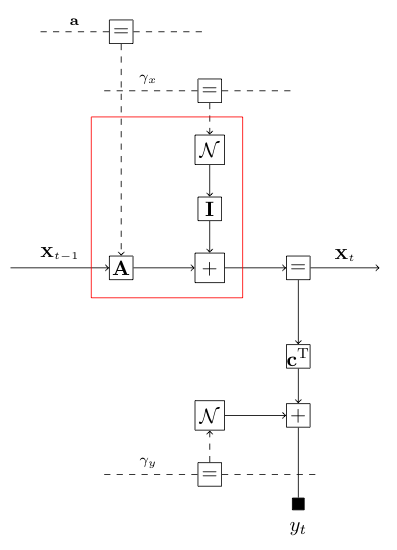

In [4]:
using Images
img = load("../ffgs/HAR-online.png")

The central quantity of our interest is a joint estimation of the AR coefficients $\mathbf{a}$ and states $\mathbf{x}_n$, while setting noises' precisions $\gamma_x=1$, $\gamma_y=\frac{1}{2}$.

In [82]:
using ProgressMeter
using Revise
using ForneyLab
include( "../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
# helpers for evaluation of the model
include("../helpers/functions.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: use_data, generate_data, generate_sin
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [98]:
ARorder = 5 # order of AR model
diagAR(dim) = Matrix{Float64}(I, dim, dim)
x = []
# AR data
a_w = 1.0; b_w = 1.0
pn_var = a_w/b_w # process noise variance
coefs, x = generate_data(1000, ARorder, 1, noise_variance=pn_var)
#x = use_data("../data/daily-minimum-temperatures.csv", ARorder)
#coefs, x = generate_sin(1000, tiny)
mn_var = 2.0 # measurement noise variance
# Observations
y = [xi[1] + sqrt(mn_var)*randn() for xi in x[ARorder:end]]

996-element Array{Float64,1}:
 -1.7608214979292791 
  0.24443146315501785
 -1.059154714857951  
 -0.4771849718461454 
 -4.678138810325029  
  1.0036531333557095 
 -0.6696936967091776 
  3.8256362759212443 
 -0.9334679594183443 
 -2.9741285376106297 
  3.206502158371017  
 -2.0329099220521583 
  6.640789218128277  
  ⋮                  
  0.1008778268689865 
  0.6226448036990713 
  1.6220875567045883 
 -1.2246889124256004 
  1.3785058634296914 
 -0.1346985477258109 
 -0.5558239779615191 
  3.5671504563570067 
 -1.0739423863874438 
  1.453770739889736  
 -6.253594572331508  
 -0.5552844463153577 

In [99]:
# Building the model
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_a_t
@RV w_a_t
@RV m_y_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w, b_w)
@RV x_t = AR(a, x_t_prev, w)
c = zeros(ARorder); c[1] = 1.0
@RV y_t ~ GaussianMeanPrecision(m_y_t, mn_var^-1)
DotProduct(y_t, c, x_t)

# Placeholders for prior
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(m_y_t, :m_y_t)

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 11892031397932213431 -->
 
 11892031397932213431 
 
 clamp_3 
 
<!-- 8692572672669621967 -->
 
 8692572672669621967 
 
 placeholder_m_x_t_prev 
 
<!-- 15831609187646028996 -->
 
 15831609187646028996 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 8692572672669621967--15831609187646028996 -->
 
 8692572672669621967--15831609187646028996 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 8506322403634385619 -->
 
 8506322403634385619 
 
 placeholder_w_a_t 
 
<!-- 9816895129070476682 -->
 
 9816895129070476682 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 8506322403634385619--9816895129070476682 -->
 
 8506322403634385619--9816895129070476682 
 
 w_a_t 
 3 w 
 1 out 
 
<!-- 15906918398381510376 -->
 
 15906918398381510376 
 
 dot 
 dotproduct_1 
 
<!-- 10972662444857911869 -->
 
 10972662444857911869 
 
 clamp_4 
 
<!-- 15906918398381510376--10972662444857911869 -->
 
 15906918398381510376--10972662444857911869 
 
 clamp_4 
 1 out 
 2 in1 
 
<!-- 15656573647308685173 -->
 
 15656573647308685173 
 
 Autoregression 
 autoregression_1 
 
<!-- 15906918398381510376--15656573647308685173 -->
 
 15906918398381510376--15656573647308685173 
 
 x_t 
 1 out 
 3 in2 
 
<!-- 5074445354481370520 -->
 
 5074445354481370520 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 15906918398381510376--5074445354481370520 -->
 
 15906918398381510376--5074445354481370520 
 
 y_t 
 1 out 
 1 out 
 
<!-- 16572409630822767043 -->
 
 16572409630822767043 
 
 placeholder_m_y_t 
 
<!-- 16572409630822767043--5074445354481370520 -->
 
 16572409630822767043--5074445354481370520 
 
 m_y_t 
 2 m 
 1 out 
 
<!-- 7842622520446494970 -->
 
 7842622520446494970 
 
 Gam 
 gamma_1 
 
<!-- 1333914929384001975 -->
 
 1333914929384001975 
 
 clamp_1 
 
<!-- 7842622520446494970--1333914929384001975 -->
 
 7842622520446494970--1333914929384001975 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 10676381792322473471 -->
 
 10676381792322473471 
 
 clamp_2 
 
<!-- 7842622520446494970--10676381792322473471 -->
 
 7842622520446494970--10676381792322473471 
 
 clamp_2 
 1 out 
 3 b 
 
<!-- 1377234362540635734 -->
 
 1377234362540635734 
 
 placeholder_m_a_t 
 
<!-- 1377234362540635734--9816895129070476682 -->
 
 1377234362540635734--9816895129070476682 
 
 m_a_t 
 2 m 
 1 out 
 
<!-- 5987164875361977442 -->
 
 5987164875361977442 
 
 placeholder_w_x_t_prev 
 
<!-- 5987164875361977442--15831609187646028996 -->
 
 5987164875361977442--15831609187646028996 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 15656573647308685173--7842622520446494970 -->
 
 15656573647308685173--7842622520446494970 
 
 w 
 1 out 
 4 W 
 
<!-- 15656573647308685173--9816895129070476682 -->
 
 15656573647308685173--9816895129070476682 
 
 a 
 1 out 
 3 a 
 
<!-- 15656573647308685173--15831609187646028996 -->
 
 15656573647308685173--15831609187646028996 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 5074445354481370520--11892031397932213431 -->
 
 5074445354481370520--11892031397932213431 
 
 clamp_3 
 1 out 
 3 w

In [100]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t, ids=[:A :X_t])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))

stepX_t! (generic function with 3 methods)

In [101]:
# Define values for prior statistics
m_a_0 = zeros(ARorder)
w_a_0 = diagAR(ARorder)
m_x_prev_0 = zeros(ARorder)
w_x_prev_0 = 0.1*diagAR(ARorder)

# Storage
m_x_prev = Vector{Vector{Float64}}(undef, length(y))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(y))
m_a = Vector{Vector{Float64}}(undef, length(y))
w_a = Vector{Array{Float64, 2}}(undef, length(y))

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_a_t_min = m_a_0
w_a_t_min = w_a_0;

In [102]:
marginals = Dict()
# VMP iterations
n_its = 10

# Storage for estimations
means = []
precisions = []
real = [x[1] for x in x[ARorder:end]]
# Storage for MSE of test set
WMSEs = []
p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_t_min, w=w_a_t_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w, b=b_w)
    global m_x_t_prev_min, w_x_t_prev_min, m_a_t_min, w_a_t_min

    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :m_a_t => m_a_t_min,
                    :w_a_t => w_a_t_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min)
        
        stepX_t!(data, marginals)
        stepA!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x_prev[t] = unsafeMean(marginals[:x_t])
        w_x_prev[t] = unsafePrecision(marginals[:x_t])
        m_a_t_min = m_a[t]
        w_a_t_min = w_a[t]
        m_x_t_prev_min = m_x_prev[t]
        w_x_t_prev_min = w_x_prev[t]
    end
    push!(means, m_x_prev[t][1])
    push!(precisions, w_x_prev[t][1])
    push!(WMSEs, wmse(real[1:t], means, 1 ./ precisions))
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:01


In [103]:
from = 1
estimated = [x[1] for x in m_x_prev[from:end]]
real = [x[1] for x in x[ARorder:end]]
noise = [y[1] for y in y[from:end]]

println("Δ(estimated, real)=", mse(estimated, real))
println("Δ(estimated, noise)=", mse(estimated, noise))
println("Δ(noise, actual)=", mse(noise, real))

Δ(estimated, real)=1.167226735245372
Δ(estimated, noise)=1.8566550743345962
Δ(noise, actual)=2.171699274672583


In [104]:
println("Inferred ", mean(marginals[:a]))
println("Real ", coefs)
mean(marginals[:w])

Inferred [-0.322791, 0.0568145, 0.0704942, -0.198848, 0.238372]
Real [-0.727472, -0.286332, -0.228492, -0.477926, 0.0845551]


1.0

In [105]:
using Plots

scale = 1.0 # scale for the variance
v_x = [v_x[1]^-1 for v_x in w_x_prev[1:end]] # variances of estimated state
toshow = 10 # number of points to plot at once

anim = @animate for i in 1:length(estimated)-toshow
    s = plot(xticks = i:div(toshow, 2):i+toshow);
    ylims!(minimum(noise) - .1, maximum(noise) + .1);
    scatter!(collect(i:i+toshow), noise[i:i+toshow], label="noisy observations", 
            markershape = :xcross, markeralpha = 0.6,
            markersize = 2)
    
    plot!(collect(i:i+toshow), [estimated[i:i+toshow], estimated[i:i+toshow]], fillrange=[estimated[i:i+toshow] -
          scale .* sqrt.(v_x[i:i+toshow]), estimated[i:i+toshow] + scale .* sqrt.(v_x[i:i+toshow])],
          linestyle=:dash, linewidth = 2,
          color=:black,
          fillalpha = 0.2,
          fillcolor = :black,
          label="inferred")
    
    plot!(collect(i:i+toshow), real[i:i+toshow], color = :magenta, linewidth = 1.0, label="real state")
end

Animation("/var/folders/jn/1xv7kskx42v_97gx1xd8y_g40000gq/T/tmpL4PSyX", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000977.png", "000978.png", "000979.png", "000980.png", "000981.png", "000982.png", "000983.png", "000984.png", "000985.png", "000986.png"])

In [106]:
gif(anim, "../gifs/KMPstate.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/KMPstate.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/KMPstate.gif")

In [107]:
# Plotting MSE
anim = @animate for i in 1:length(WMSEs)
    s = plot()
    ylims!(minimum(WMSEs) - 1, maximum(WMSEs) + 1)
    xlims!(1, length(WMSEs))
    plot!(collect(1:i), WMSEs[1:i], xlabel="observation", ylabel="WMSE", label="")
end;

In [108]:
gif(anim, "../gifs/MSE_evo_state.gif", fps = 100)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSE_evo_state.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSE_evo_state.gif")

# Random walk model 
As a benchamrk, we use the following RW model.
\begin{align*}
    &x_t = x_{t-1} + p_t \quad p_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = x_t + m_t \quad m_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

We set $\gamma_y = 1.0$ and $\gamma_y = \frac{1}{2}$

In [109]:
rwg = FactorGraph()

# declare priors as random variables
@RV m_x_t_min
@RV w_x_t_min
@RV x_t_min ~ GaussianMeanPrecision(m_x_t_min, w_x_t_min)

@RV n_t ~ GaussianMeanPrecision(0.0, 1.0)
@RV x_t = x_t_min + n_t
@RV m_t ~ GaussianMeanPrecision(0.0, mn_var^-1)
@RV y_t = x_t + m_t

# Placeholders for prior
placeholder(m_x_t_min, :m_x_t_min)
placeholder(w_x_t_min, :w_x_t_min)

# Placeholder for data
placeholder(y_t, :y_t)
ForneyLab.draw(rwg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 7595229730246288432 -->
 
 7595229730246288432 
 
 placeholder_w_x_t_min 
 
<!-- 6770326340904392082 -->
 
 6770326340904392082 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 7595229730246288432--6770326340904392082 -->
 
 7595229730246288432--6770326340904392082 
 
 w_x_t_min 
 3 w 
 1 out 
 
<!-- 1980371983869571779 -->
 
 1980371983869571779 
 
 + 
 addition_2 
 
<!-- 5759659710351065782 -->
 
 5759659710351065782 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 1980371983869571779--5759659710351065782 -->
 
 1980371983869571779--5759659710351065782 
 
 m_t 
 1 out 
 3 in2 
 
<!-- 16686474227805334758 -->
 
 16686474227805334758 
 
 + 
 addition_1 
 
<!-- 1980371983869571779--16686474227805334758 -->
 
 1980371983869571779--16686474227805334758 
 
 x_t 
 1 out 
 2 in1 
 
<!-- 907213104565098082 -->
 
 907213104565098082 
 
 placeholder_y_t 
 
<!-- 907213104565098082--1980371983869571779 -->
 
 907213104565098082--1980371983869571779 
 
 y_t 
 1 out 
 1 out 
 
<!-- 2451445330722923908 -->
 
 2451445330722923908 
 
 clamp_4 
 
<!-- 5759659710351065782--2451445330722923908 -->
 
 5759659710351065782--2451445330722923908 
 
 clamp_4 
 1 out 
 3 w 
 
<!-- 8284240979182764825 -->
 
 8284240979182764825 
 
 clamp_3 
 
<!-- 5759659710351065782--8284240979182764825 -->
 
 5759659710351065782--8284240979182764825 
 
 clamp_3 
 1 out 
 2 m 
 
<!-- 1638430017884322875 -->
 
 1638430017884322875 
 
 clamp_2 
 
<!-- 5560360233321503011 -->
 
 5560360233321503011 
 
 placeholder_m_x_t_min 
 
<!-- 5560360233321503011--6770326340904392082 -->
 
 5560360233321503011--6770326340904392082 
 
 m_x_t_min 
 2 m 
 1 out 
 
<!-- 1156618591370085850 -->
 
 1156618591370085850 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 16686474227805334758--1156618591370085850 -->
 
 16686474227805334758--1156618591370085850 
 
 n_t 
 1 out 
 3 in2 
 
<!-- 16686474227805334758--6770326340904392082 -->
 
 16686474227805334758--6770326340904392082 
 
 x_t_min 
 1 out 
 2 in1 
 
<!-- 13792213078435873362 -->
 
 13792213078435873362 
 
 clamp_1 
 
<!-- 1156618591370085850--1638430017884322875 -->
 
 1156618591370085850--1638430017884322875 
 
 clamp_2 
 1 out 
 3 w 
 
<!-- 1156618591370085850--13792213078435873362 -->
 
 1156618591370085850--13792213078435873362 
 
 clamp_1 
 1 out 
 2 m

In [110]:
algo = sumProductAlgorithm(x_t)
eval(Meta.parse(algo))

# Define values for prior statistics
m_x_0 = 0.0
w_x_0 = 0.01

n_samples = length(y)
m_x = Vector{Float64}(undef, n_samples)
w_x = Vector{Float64}(undef, n_samples)

m_x_t_min = m_x_0
w_x_t_min = w_x_0

# Storage for estimations
means_rw = []
precisions_rw = []
real_rw = [x[1] for x in x[ARorder:end]]
# Storage for MSE of test set
WMSEs_rw = []

for t = 1:n_samples
    # Prepare data and prior statistics
    data = Dict(:y_t        => y[t],
                :m_x_t_min => m_x_t_min,
                :w_x_t_min => w_x_t_min)
    
    # Execute algorithm
    marginals = step!(data)

    # Extract posterior statistics
    m_x_t_min = mean(marginals[:x_t])
    w_x_t_min = var(marginals[:x_t])^-1
    
    # Store to buffer 
    m_x[t] = m_x_t_min
    w_x[t] = w_x_t_min
    push!(means_rw, m_x_t_min)
    push!(precisions_rw, w_x_t_min)
    push!(WMSEs_rw, wmse(real[1:t], means_rw, 1 ./ precisions_rw))
end

# Comparison
To assess the performance of our model, we use the following metric:
$$\sum_{i=1}^Te^{i-T}\frac{(m_{x_{k}}-x_{k})^2}{{v_{x_{k}}}}$$
where
$m_{x_{k}}$ - estimated mean of the hidden state,
$v_{x_{k}}$ - estimated variance of the hidden state,
$T$ - number of available observations

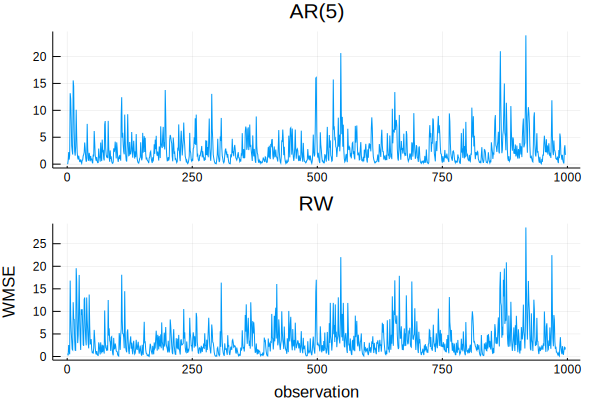

In [111]:
# Plotting
using Plots
pAR = plot(WMSEs, title="AR($ARorder)", label="")
pRW = plot(WMSEs_rw, xlabel="observation", ylabel="WMSE", title="RW", label="")
plot(pAR, pRW, layout=(2,1))

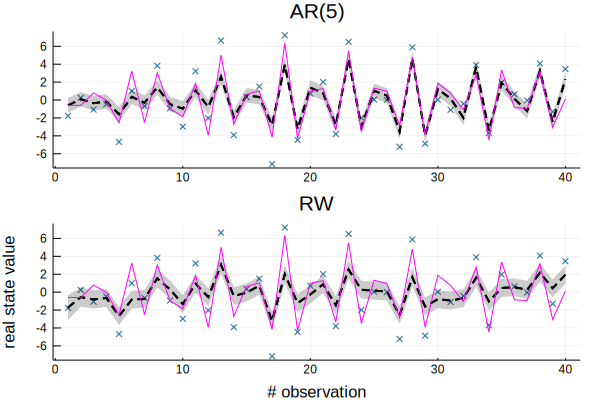

In [112]:
from = 1
upto = 40 # limit for building a graph 
scale = 1.0 # scale for the variance
v_x = [v_x[1]^-1 for v_x in w_x[1:end]] # variances of estimated state
scatter(noise[from:upto], label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([m_x[from:upto], m_x[from:upto]], fillrange=[m_x[from:upto] -
      scale .* sqrt.(v_x[from:upto]), m_x[from:upto] +
      scale .* sqrt.(v_x[from:upto])],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(real[from:upto], color = :magenta, linewidth = 1.0, label="real state")
pRW = plot!(xlabel="# observation", ylabel="real state value", title="RW")


v_x = [v_x[1]^-1 for v_x in w_x_prev[1:end]] # variances of estimated state
scatter(noise[from:upto], label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([estimated[from:upto], estimated[from:upto]], fillrange=[estimated[from:upto] -
      scale .* sqrt.(v_x[from:upto]), estimated[from:upto] +
      scale .* sqrt.(v_x[from:upto])],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(real[from:upto], color = :magenta, linewidth = 1.0, label="real state")
pAR = plot!(title="AR($ARorder)", legend=false)

plot(pAR, pRW, layout=(2,1), legend=false)

In [113]:
sum(WMSEs)

2757.711006269165

In [114]:
sum(WMSEs_rw)

3610.8318451020914